# Required Packages

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load and Pre-process Dataset

In [2]:
# Load the Shakespeare dataset from a file
def load_shakespeare_from_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    return text

# Load and preprocess data
file_path = 'input.txt'  # Path to your text file
text = load_shakespeare_from_file(file_path)

In [3]:
# Preprocess the text data: Tokenize and encode
def preprocess_text(text):
    #Tokenizer object
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=False, oov_token='<UNK>')
    #Text to sequences
    tokenizer.fit_on_texts([text])
    sequences = tokenizer.texts_to_sequences([text])[0]
    #Tokens index
    word_index = tokenizer.word_index
    index_word = tokenizer.index_word
    return sequences, word_index, index_word, tokenizer

# Create training sequences
def create_training_sequences(sequences, seq_length):
    inputs = []
    targets = []
    for i in range(len(sequences) - seq_length):
        inputs.append(sequences[i:i+seq_length])
        targets.append(sequences[i+1:i+seq_length+1])
    return np.array(inputs), np.array(targets)


#get sequences
sequences, word_index, index_word, tokenizer = preprocess_text(text)

#vocabulary size
vocab_size = len(word_index) + 1  # Plus one for the OOV token
seq_length = 20
#Prepare data for auto-regressive learning
inputs, targets = create_training_sequences(sequences, seq_length)

# Create TensorFlow dataset
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size, drop_remainder=True)

# Auto-regressive Decoder

In [4]:
class SimpleTransformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model):
        super(SimpleTransformer, self).__init__()
        #embedding and positional encoding layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.positional_encoding = self.get_positional_encoding(vocab_size, d_model)
        
        #Query, Key and Value weight matrices
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        #output layer
        self.dense = tf.keras.layers.Dense(d_model)
        self.output_dense = tf.keras.layers.Dense(vocab_size)

    #Positional encoding
    def get_positional_encoding(self, position, d_model):
        #get angles
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        #apply sine to even and cosine to odd dimensions
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        #add new axis and convert to tensor
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    #angles for the encodings
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates
    
    #Create causal mask
    def create_causal_mask(self, seq_len):
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return mask[tf.newaxis, :, :]  # Add only the batch dimension
    
    #model forward pass
    def call(self, x):
        #sequence length
        seq_len = tf.shape(x)[1]
        #embeddings and positional encodings
        x = self.embedding(x)
        x += self.positional_encoding[:, :seq_len, :]
        
        #create mask
        causal_mask = self.create_causal_mask(seq_len)
        
        #Query, key and value matrix
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        
        #compute attention score and normalize
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if causal_mask is not None:
            # add high negative value to upper values
            scaled_attention_logits += (causal_mask * -1e9)
        
        #apply softmax and compute attention output
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_output = tf.matmul(attention_weights, v)
        
        #fully connected layer
        output = self.dense(attention_output)
        
        #model output
        output = self.output_dense(output)
        return output

In [5]:
# model dimension
d_model = 32

# Create the model
model = SimpleTransformer(vocab_size, d_model)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Train the model
epochs = 10
history = model.fit(dataset, epochs=epochs)

Epoch 1/10
1327/1327 [==============================] - 33s 24ms/step - loss: 7.3447
Epoch 2/10
1327/1327 [==============================] - 32s 24ms/step - loss: 6.2519
Epoch 3/10
1327/1327 [==============================] - 32s 24ms/step - loss: 5.3566
Epoch 4/10
1327/1327 [==============================] - 33s 25ms/step - loss: 4.6325
Epoch 5/10
1327/1327 [==============================] - 33s 25ms/step - loss: 4.0677
Epoch 6/10
1327/1327 [==============================] - 33s 25ms/step - loss: 3.6585
Epoch 7/10
1327/1327 [==============================] - 33s 25ms/step - loss: 3.3525
Epoch 8/10
1327/1327 [==============================] - 33s 25ms/step - loss: 3.0795
Epoch 9/10
1327/1327 [==============================] - 33s 25ms/step - loss: 2.8351
Epoch 10/10
1327/1327 [==============================] - 33s 25ms/step - loss: 2.6200


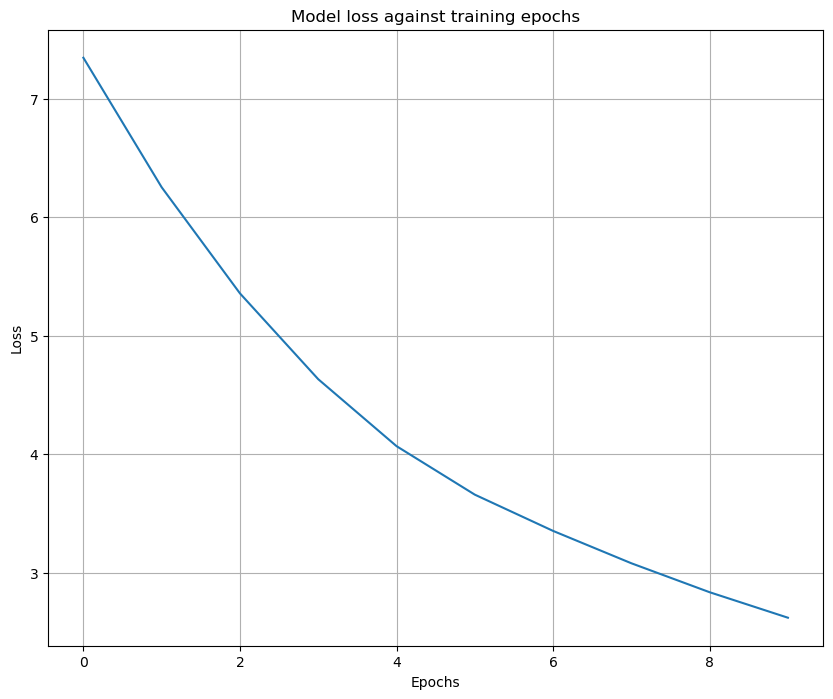

In [6]:
#Model Learning Curve
plt.figure(figsize=(10,8),dpi=100)
plt.plot(range(epochs), history.history['loss'])
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model loss against training epochs");

In [7]:
# Test the model with some random input
def generate_text(model, tokenizer, seq_length, seed_text, num_words):
    for _ in range(num_words):
        tokenized_input = tokenizer.texts_to_sequences([seed_text])[0]
        tokenized_input = tf.constant(tokenized_input[-seq_length:])[tf.newaxis, :]
        predictions = model(tokenized_input)
        predicted_id = tf.argmax(predictions[0, -1, :]).numpy()
        seed_text += ' ' + tokenizer.index_word.get(predicted_id)
    return seed_text

# Example of text generation
seed_text = "To be or not to be"
generated_text = generate_text(model, tokenizer, seq_length, seed_text, num_words=30)
print("Generated text:", generated_text)

Generated text: To be or not to be desert,--

SEBASTIAN:
Ha, ha, ha! So, you're paid.

ADRIAN:
Uninhabitable and almost inaccessible,--

SEBASTIAN:
Yet,--

ADRIAN:
Yet,--

ANTONIO:
He could not miss't.

ADRIAN:
It must be of so to curse. The red plague not to sleep.

ANTONIO:
Nor I; my comfort, but for the


In [8]:
# Calculate the total number of parameters
total_params = sum(layer.count_params() for layer in model.layers)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 2747094


# Model Shapes

In [9]:
class SimpleTransformer(tf.keras.Model):
    def __init__(self, vocab_size, d_model):
        super(SimpleTransformer, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.positional_encoding = self.get_positional_encoding(vocab_size, d_model)
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        self.output_dense = tf.keras.layers.Dense(vocab_size)

    def get_positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)
    
    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates
    
    def create_causal_mask(self, seq_len):
        mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
        return mask[tf.newaxis, :, :]  
    
    def call(self, x):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        print(f"Embedding output shape: {x.shape}")
        pos_enc = self.positional_encoding[:, :seq_len, :]
        print(f"Positional encoding shape before broadcasting: {pos_enc.shape}")
        x += pos_enc
        print(f"Shape after adding positional encoding: {x.shape}")

        causal_mask = self.create_causal_mask(seq_len)
        print(f"Causal mask shape: {causal_mask.shape}")

        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        print(f"Query shape: {q.shape}")
        print(f"Key shape: {k.shape}")
        print(f"Value shape: {v.shape}")

        print(f"Query weights shape: {self.wq.weights[0].shape}")
        print(f"Key weights shape: {self.wk.weights[0].shape}")
        print(f"Value weights shape: {self.wv.weights[0].shape}")

        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if causal_mask is not None:
            scaled_attention_logits += (causal_mask * -1e9)
        
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        print(f"Attention weights shape: {attention_weights.shape}")
        attention_output = tf.matmul(attention_weights, v)
        print(f"Attention output shape: {attention_output.shape}")

        output = self.dense(attention_output)
        print(f"Dense layer output shape: {output.shape}")

        output = self.output_dense(output)
        print(f"Final output shape: {output.shape}")
        return output

# Create the model
vocab_size = 10000  # Example vocabulary size
d_model = 512  # Example embedding dimension
model = SimpleTransformer(vocab_size, d_model)

# Generate random input data
batch_size = 2
seq_len = 10
random_input = tf.random.uniform((batch_size, seq_len), minval=0, maxval=vocab_size, dtype=tf.int32)

# Pass the random data through the model
output = model(random_input)

Embedding output shape: (2, 10, 512)
Positional encoding shape before broadcasting: (1, 10, 512)
Shape after adding positional encoding: (2, 10, 512)
Causal mask shape: (1, 10, 10)
Query shape: (2, 10, 512)
Key shape: (2, 10, 512)
Value shape: (2, 10, 512)
Query weights shape: (512, 512)
Key weights shape: (512, 512)
Value weights shape: (512, 512)
Attention weights shape: (2, 10, 10)
Attention output shape: (2, 10, 512)
Dense layer output shape: (2, 10, 512)
Final output shape: (2, 10, 10000)
